In [35]:
import numpy as np
import sympy as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [3]:
def jordan_wigner_majorana(N):
    """
    Jordan-Wigner transformation for Majorana fermions.

    Parameters:
    - N: int, number of fermions

    Returns:
    - G_matrix: 2N x 2N matrix representing the Jordan-Wigner transformation
    """

    # Initialize the Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    # Identity matrix
    I = np.eye(2)

    # Initialize the Jordan-Wigner matrix
    G_matrix = np.zeros((2*N, 2*N), dtype=complex)

    for i in range(N):
        # Construct the ith Majorana operator
        operator_i = np.kron(np.eye(2**i), np.kron(sigma_z, I))
        
        # Construct the product term for the Jordan-Wigner matrix
        product_term = np.eye(1)
        for j in range(N):
            if j < i:
                product_term = np.kron(product_term, sigma_z)
            elif j > i:
                product_term = np.kron(product_term, sigma_x - 1j * sigma_y)

        # Update the Jordan-Wigner matrix
        G_matrix += operator_i @ product_term

    return G_matrix


In [58]:
import numpy as np
from qutip import qeye, sigmax, sigmay, sigmaz, tensor, create, destroy

def Is(i, levels=2): return [qeye(levels) for j in range(0, i)]

def Sx(N, i): return tensor(Is(i) + [sigmax()] + Is(N - i - 1))
def Sy(N, i): return tensor(Is(i) + [sigmay()] + Is(N - i - 1))
def Sz(N, i): return tensor(Is(i) + [sigmaz()] + Is(N - i - 1))

def I(N): return Sz(N, 0)*Sz(N, 0)

def b_(N, Np, i): return tensor(Is(i, levels=Np+1) + [destroy(Np+1)] + Is(N - i - 1, levels=Np+1))
def bd(N, Np, i): return tensor(Is(i, levels=Np+1) + [create(Np+1)] + Is(N - i - 1, levels=Np+1))

def osum(lst): return np.sum(np.array(lst, dtype=object))

def oprd(lst, d=None):
    if len(lst) == 0:
        return d
    p = lst[0]
    for U in lst[1:]:
        p = p*U
    return p

# N is the exponent, L is the length of the chain
def opow(L, op, N): return oprd([op for i in range(N)])


def commutator(A, B):
    return A*B - B*A


def anticommutator(A, B):
    return A*B + B*A


def a_(N, n, Opers=None):
    Sa, Sb, Sc = Sz, Sx, Sy
    if Opers is not None:
        Sa, Sb, Sc = Opers
    return oprd([Sa(N, j) for j in range(n)], d=I(N))*(Sb(N, n) + 1j*Sc(N, n))/2.

def gamma_a(N, n, Opers=None):
    Sa, Sb, Sc = Sz, Sx, Sy
    if Opers is not None:
        Sa, Sb, Sc = Opers
    return oprd([Sb(N, j) for j in range(n)], d=I(N)) * Sa(N, n)

def ad(N, n, Opers=None):
    Sa, Sb, Sc = Sz, Sx, Sy
    if Opers is not None:
        Sa, Sb, Sc = Opers
    return oprd([Sa(N, j) for j in range(n)], d=I(N))*(Sb(N, n) - 1j*Sc(N, n))/2.

def gamma_b(N, n, Opers=None):
    Sa, Sb, Sc = Sz, Sx, Sy
    if Opers is not None:
        Sa, Sb, Sc = Opers
    return oprd([Sb(N, j) for j in range(n)], d=I(N)) * Sc(N, n)


In [29]:
commutator(gamma_a(3,0), gamma_a(3, 0))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

In [64]:
gamma_b(2, 0)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j]]

In [156]:
a_(3, 2)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

In [51]:
def testFermions(N, jw):
    (Sa, _), (Sb, _), (Sc, _) = jw
    Opers = Sa, Sb, Sc
    zero = 0.*I(N)
    # test all the pairs
    for n in range(N):
        a_n = a_(N, n, Opers=Opers)
        adn = ad(N, n, Opers=Opers)
        for np in range(N):
            a_np = a_(N, np, Opers=Opers)
            adnp = ad(N, np, Opers=Opers)
            assert anticommutator(a_n, a_np) == zero
            if n == np:
                assert anticommutator(a_n, adnp) == I(N)
            else:
                assert anticommutator(a_n, adnp) == zero
        assert a_n*a_n == zero
        assert adn*adn == zero

## measurement-only braiding, symbolisim

In [5]:
N = 6
S_num = 8
S = [sm.symbols(f"S_{i}") for i in range(1,S_num+1)]
gamma = [sm.symbols(f'\gamma_{i}') for i in range(1, N+1)]
M = sm.symbols('M')

def prj_meas(i, j, s):
    return (1 + sm.I * S[s-1] * gamma[i-1] * gamma[j-1])

In [6]:
sm.Eq(M, prj_meas(2, 3, 1) * prj_meas(4, 5, 2)
       * prj_meas(1, 2, 3) * prj_meas(3, 4, 4)
       * prj_meas(2, 4, 5) * prj_meas(3, 6, 6)
       * prj_meas(2, 3, 7) * prj_meas(2, 5, 8))

Eq(M, (I*S_1*\gamma_2*\gamma_3 + 1)*(I*S_2*\gamma_4*\gamma_5 + 1)*(I*S_3*\gamma_1*\gamma_2 + 1)*(I*S_4*\gamma_3*\gamma_4 + 1)*(I*S_5*\gamma_2*\gamma_4 + 1)*(I*S_6*\gamma_3*\gamma_6 + 1)*(I*S_7*\gamma_2*\gamma_3 + 1)*(I*S_8*\gamma_2*\gamma_5 + 1))

In [103]:
def sigma_x(N=1):
    mat = np.array([
        [0, 1],
        [1, 0]
    ])
    return mat
    
def sigma_y():
    mat = np.array([
        [0, -1j],
        [1j, 0]
    ])
    return mat
    
def sigma_z():
    mat = np.array([
        [1, 0],
        [0, -1]
    ])
    return mat

def gamma_a(j, N=1):
    res = I(N)
    for k in range(1, j):
        res * Sx(N, 0)
    return res * sigma_
    
def gamma_b(j, N=1):
    res = I(N)
    for k in range(1, j):
        res * Sx(N, 0)
    return res * Sz(N, 0) 
    

-1

## Visualization of Dots

In [48]:
def gen_conf(N):
    ''' N is number of pairs of
    Majorona fermions'''
    x = list(range(2 * (N-1)))
    y = [0] * len(x)
    
    # middle pair
    mid = x[-1] / 2
    x += [mid, mid]
    y += [-1, -2]
    
    return x, y

def plot_conn(fig, conf, step=1):
    x, y = conf
    fig = plt.get_current_fig_manager
    if step in [1, 4]:
        x = []


    return x, y

In [53]:
fig, ax = fig

AttributeError: 'FigureManagerBase' object has no attribute 'plot'

<Figure size 800x550 with 0 Axes>

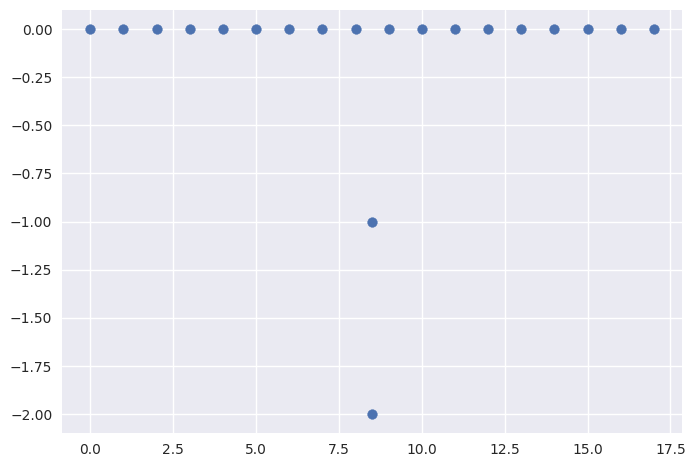

In [56]:
conf = gen_conf(10)

plt.scatter(*conf)
plt.show()

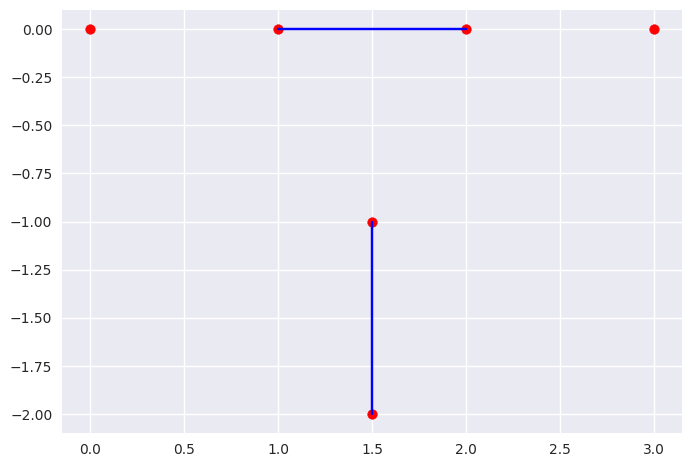

In [36]:
xpos = [0, 1, 2, 3, 1.5, 1.5]
ypos = [0, 0, 0, 0, -1, -2]
 
conn = [
    [
        [1, 2],
        [0, 0]
    ],
    [
        [1.5, 1.5],
        [-1, -2]
    ]
]

for line in conn:
    plt.plot(*line, c='b')
plt.scatter(xpos, ypos, c='r')
plt.show()

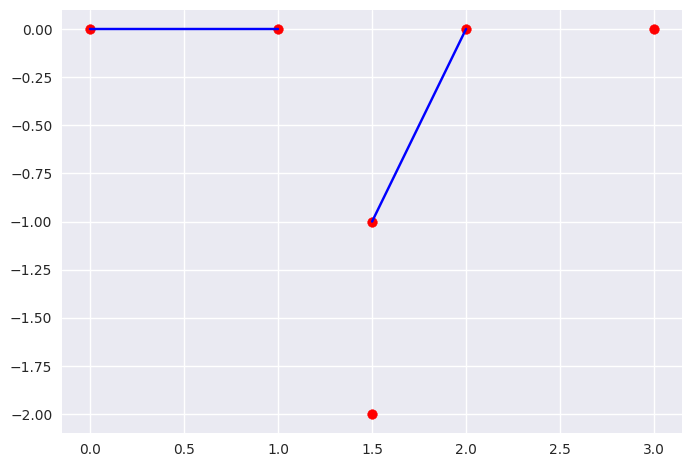

In [37]:
conn = [
    [
        [0, 1],
        [0, 0]
    ],
    [
        [1.5, 2],
        [-1, 0]
    ]
]

for line in conn:
    plt.plot(*line, c='b')
plt.scatter(xpos, ypos, c='r')
plt.show()

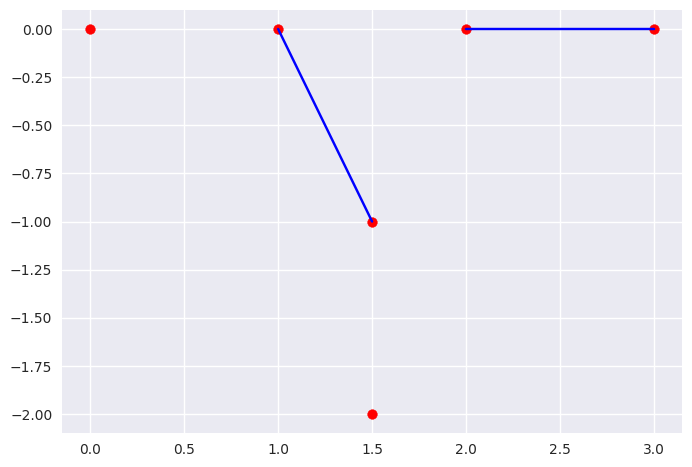

In [38]:
conn = [
    [
        [2, 3],
        [0, 0]
    ],
    [
        [1, 1.5],
        [0, -1]
    ]
]

for line in conn:
    plt.plot(*line, c='b')
plt.scatter(xpos, ypos, c='r')
plt.show()